River Kelly & Kyler Gappa

CSCI-347: Data Mining

Project 02: Exploring Graph Data

Partner work is allowed on this project.

Choose a data set that you are interested in from one of the following sources:
- SNAP collection: https://snap.stanford.edu/data
- Network Repository: http://networkrepository.com/index.php

Run all the analysis in this project on the largest connected component of the graph. Note that many of these datasets are quite large. If analyzing the data its taking too long, you may pre-process it by taking a sample of the graph first, and then extracting the largest connected component, to get the graph down to a manageable size.

# Python Setup Code

In [ ]:
# import libraries
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import urllib.request
import io
import gzip
import random as rd

In [ ]:
DATA_URL = 'https://snap.stanford.edu/data/facebook_combined.txt.gz'

In [ ]:
def getFileData(url: str) -> list:
    response = urllib.request.urlopen(url)
    compressed_file = io.BytesIO(response.read())
    decompressed_file = gzip.GzipFile(fileobj=compressed_file)
    # read file to edges list
    edges: list = list()
    while True:
        line = decompressed_file.readline()
        if not line: break # no more lines to read
        # parse line string
        line = str(line.decode("utf-8")).strip()
        edge_str_data = line.split(' ')
        point_1 = int(edge_str_data[0])
        point_2 = int(edge_str_data[1])
        edge = (point_1, point_2)
        edges.append(edge)
    decompressed_file.close()
    compressed_file.close()
    return edges

# Part 1: Think about the data

This data set is interesting because it shows the connectivity of each person social circle. This can lead to a better understanding of how people with different interests connect to each other. We expect that nodes with a high level of centrality to be people with a large amount of popular interests. These people could then be good to advertise around as they are most likely to influence a large population. We did not take a sample of the elements from the data set.

# Part 2: Write Python code for graph analysis

Write the following functions in Python. You may assume that the input graph is unweighted,
undirected, and simple – has no parallel edges and no loops. Functions provided by networkx can
be used within your code, as long as the function does not perform the same task as what you
are being asked to implement. For example, you cannot use networkx’s betweenness centrality
function within your own betweenness centrality function, but you can use networkx’s functions for
finding shortest paths. You may also assume that vertices are represented as integers (so the pair
(1,3) indicates that there is an edge between vertex 1 and 3, for example).

## 1. (5 points) Number of vertices

A function that takes the following input: a list of edges representing a graph, where each edge is a pair. The output should be the number of vertices.

In [ ]:
# numberOfVertices() - returns the number of vertices
# params: 
#   - edges: list
def numberOfVertices(edges: list):
    # list to maintain the individual vertices
    vertices_list = list()
    # loop through list of edges
    for edge in edges:
        # loop through each vertex in the edge
        for vertex in edge:
            # check if vertex has already been accounted for in the list
            if vertex not in vertices_list:
                # add the vertex to the list of all vertices
                vertices_list.append(vertex)
    # return the length of the vertices list (i.e. the total number of vertices)
    return len(vertices_list)

## 2. (5 points) Degree of a vertex

A function that takes the following input: a list of edges representing a graph, where each edge is a pair, and a vertex index that is an integer. The output should be the degree of the input vertex.

In [ ]:
# vertexDegree() - Computes the degree of a given vertex
# params:
#   - edges: list 
#   - vertex: int
def vertexDegree(edges: list, vertex: int, returnAdjacentVertexList: bool = False):
    # list of adjacent verticies
    adjacent_vertices_list = list()
    # loop through the list of edges (i.e list of vertice 
    # pairs that make up the edges)
    for edge in edges:
        # does the edge contain the vertex of interest
        if vertex not in edge:
            # skip this edge, not vertices of interes
            continue
        # this edge does contain a vertice of interest.
        # lets loop through each of the vertices that make up the
        # edge and see if we need to count it
        for edge_vertex in edge:
            # is this edge_vertex the vertex of interest
            if edge_vertex == vertex:
                # it is, so lets skip it
                continue
            # have we already counted this vertice
            if edge_vertex in adjacent_vertices_list:
                # we have, so lets skip it
                continue
            # append the vertice to the list of adjacent vertices
            adjacent_vertices_list.append(edge_vertex)
    if returnAdjacentVertexList is True:
        return adjacent_vertices_list
    return len(adjacent_vertices_list)

## 3. (5 points) Clustering coefficient of a vertex

A function that takes the following input: a list of edges representing a graph, where each edge is a pair, and a vertex index that is an integer. The output should be the clustering coefficient of the input vertex.

In [ ]:
def vertexClusteringCoefficient(edges: list, vertex: int):
    adjacent_vertices_list = vertexDegree(edges=edges, vertex=vertex, returnAdjacentVertexList=True)
    neighbor_edge_dict = dict()
    edges_amoung_neighbors = list()
    for edge in edges:
        p1 = edge[0]
        p2 = edge[1]
        if p1 not in adjacent_vertices_list or p2 not in adjacent_vertices_list: continue
        if p2 in neighbor_edge_dict:
            if p1 not in neighbor_edge_dict[p2]:
                neighbor_edge_dict[p2].append(p1)
            continue
        if p1 not in neighbor_edge_dict:
            neighbor_edge_dict[p1] = list()
        if p2 not in neighbor_edge_dict[p1]:
            neighbor_edge_dict[p1].append(p2)
        edges_amoung_neighbors.append(edge)
    num_edges_amoung_neighbors = len(edges_amoung_neighbors)
    num_of_neighbor_vertices = len(adjacent_vertices_list)
    answer = 0
    # avoid division by 0
    try:
        num_possible_edges = (num_of_neighbor_vertices * (num_of_neighbor_vertices - 1) ) / 2
        answer = num_edges_amoung_neighbors / num_possible_edges
    except:
        pass
    return answer

## 4. (5 points) Betweenness centrality of a vertex

A function that takes the following input: a list of edges representing a graph, where each edge is a pair, and a vertex index that is an integer. The output should be the betweenness centrality of the input vertex.

In [ ]:
shortest_path_dict = dict()
shortest_path_len_dict = dict()
def getShortestPath(betweenness_G, v1, v2):
    global shortest_path_dict
    lower_v = v1
    greater_v = v2
    if v1 <= v2:
        lower_v = v1
        greater_v = v2
    else:
        lower_v = v2
        greater_v = v1

    if lower_v in shortest_path_dict and greater_v in shortest_path_dict[lower_v]:
        return shortest_path_dict[lower_v][greater_v]
    elif greater_v in shortest_path_dict and lower_v in shortest_path_dict[greater_v]:
        return shortest_path_dict[greater_v][lower_v]
    else:
        shortest_path = nx.shortest_path(betweenness_G, lower_v, greater_v)
        shortest_path_dict[lower_v][greater_v] = shortest_path
        return shortest_path

def getShortestPathLength(betweenness_G, v1, v2):
    global shortest_path_len_dict
    lower_v = v1
    greater_v = v2
    if v1 <= v2:
        lower_v = v1
        greater_v = v2
    else:
        lower_v = v2
        greater_v = v1

    if lower_v in shortest_path_len_dict and greater_v in shortest_path_len_dict[lower_v]:
        return shortest_path_len_dict[lower_v][greater_v]
    elif greater_v in shortest_path_len_dict and lower_v in shortest_path_len_dict[greater_v]:
        return shortest_path_len_dict[greater_v][lower_v]
    else:
        shortest_path_len = nx.shortest_path_length(betweenness_G, lower_v, greater_v)
        shortest_path_len_dict[lower_v][greater_v] = shortest_path_len
        return shortest_path_len

betweenness_vertices = None
betweenness_G = None

def vertexBetweennessCentrality(edges: list, source_vertex: int):
    global betweenness_vertices
    global betweenness_G
    if betweenness_vertices is None:
        betweenness_vertices = list()
        betweenness_G = nx.Graph()
        for edge in edges:
            betweenness_vertices.append(edge[0])
            betweenness_vertices.append(edge[1])
            betweenness_G.add_edge(edge[0], edge[1])
        betweenness_vertices = set(betweenness_vertices)
    vertices = betweenness_vertices
    already_compared = dict()
    def hasBeenCompared(v1, v2):
        if v1 not in already_compared: already_compared[v1] = list()
        if v2 not in already_compared[v1]:
            already_compared[v1].append(v2)
            return False
        if v2 in already_compared:
            if v1 not in already_compared[v2]:
                already_compared[v2].append(v1)
                return False
        return True

    answer = 0
    for vertex1 in vertices:
        if vertex1 == source_vertex: continue
        for vertex2 in vertices:
            if vertex2 == source_vertex: continue
            if hasBeenCompared(vertex1, vertex2): continue
            sub_top = 0
            sub_bottom = 0
            sub_answer = 0
            try:
                shortest_path = getShortestPath(betweenness_G, vertex1, vertex2)
                shortest_path_len = getShortestPathLength(betweenness_G, vertex1, vertex2)
                # shortest_path = nx.shortest_path(G, vertex1, vertex2)
                # shortest_path_len = nx.shortest_path_length(G, vertex1, vertex2)
                if source_vertex in shortest_path:
                    sub_top += 1
                if shortest_path_len > 0:
                    sub_bottom += 1
                sub_answer = sub_top / sub_bottom
            except:
                continue
            answer += sub_answer

    return answer

## 5. (5 points) Adjacency matrix

A function that takes the following input: a list of edges representing a graph, where each edge is a pair. The output should be the dense adjacency matrix of the graph.

In [ ]:
def adjacencyMatrix(edges: list):
    num_of_vertices = numberOfVertices(edges=edges)
    m = np.ndarray(shape=(num_of_vertices, num_of_vertices), dtype=int) # output matrix
    # zero values
    for row in range(m.shape[0]):
        m[row] = np.array([0] * m.shape[1])
    for edge in edges:
        m[edge[0] - 1][edge[1] - 1] = 1
    return m

## 6. (10 points) Prestige centrality of vertices

A function that takes the following input: a dense adjacency matrix representation of a graph. The output should be the prestige values for each vertex in the graph. (Note, you may NOT use linear algebra functions in numpy, spicy, or any other library to find eigenvectors but you MAY use linear algebra functions for transpose, matrix-vector multiplication, computing the dot product, the norm, and argmax.)

In [ ]:
def prestige_centrality(m: np.matrix, max_iter = 100000):
    # validate matrix data type
    if not isinstance(m, np.matrix):
        raise TypeError("matrix `m` must be type `np.matrix`")
    # transpose matrix
    a = m.transpose()
    # a = m

    p_0 = np.array([1] * a.shape[0])
    p_arr = list()
    p_arr.append(p_0)


    # power iteration
    iter_count = 0
    while True:
        iter_count += 1
        if iter_count > max_iter: break
        p_j = [0] * a.shape[0]
        p_i = p_arr[len(p_arr) - 1]
        j_index = 0
        for i in a:
            a_i_row = np.array(i).flatten()
            p_j[j_index] = np.dot(a_i_row, p_i)
            j_index += 1
        # normalize the vector
        p_j = p_j / np.amax(p_j)
        p_arr.append(p_j)
        converged = True
        for p_j_index in range(len(p_j)):
            j_val = p_j[p_j_index]
            i_val = p_i[p_j_index]
            i_j_diff = abs(j_val - i_val)
            if i_j_diff > 0.00001:
                converged = False
                break
        if converged is True:
            break

    return p_arr[len(p_arr) - 1]

# Part 3: Analyze the graph data

Using tables or figures as appropriate, report the following. You may treat the graph as a simple undirected, unweighted graph. You may use networkx functions in all of Part 3, but you are encouraged to test out your functions from Part 2 on real-world data.

## Code Setup

Get list of edges from the real world data.

In [ ]:
edges = getFileData(DATA_URL)

Create a NetworkX Graph from the real world data.

In [ ]:
# G will be the complete graph of all the edged from the real world data.
G = nx.Graph()
# add edges to the graph
for edge in edges: G.add_edge(edge[0], edge[1])
# Show graph info
nx.info(G)

'Graph with 4039 nodes and 88234 edges'

### Helper Functions

The following are some common methods that will be used.

In [ ]:
# function to sort a dictionary by its values
def sortDictionaryByValues(d: dict, ascending: bool = True):
    # validate the input `d` is type dictionary
    if not isinstance(d, dict):
        raise TypeError("`d` must be type `dict`.")
    # return the sorted dictionary
    return {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=ascending)}

In [ ]:
# this method returns a dictionary containing the first elements
# through a given limit. (i.e. elements 0-n)
def limitNumDictionaryElements(d: dict, limit: int = 10):
    # validate the input `d` is type dictionary
    if not isinstance(d, dict):
        raise TypeError("`d` must be type `dict`.")
    # return the limited dictionary
    return {k: v for k, v in list(d.items())[:limit]}

In [ ]:
# This method combines sortDictionaryByValues() and limitNumDictionaryElements()
def topSortedDict(d: dict, ascending: bool = True, limit: int = 10):
    # validate the input `d` is type dictionary
    if not isinstance(d, dict):
        raise TypeError("`d` must be type `dict`.")
    return limitNumDictionaryElements(sortDictionaryByValues(d, ascending), limit)

In [ ]:
# converts a dictionary to a sorted list where each
# elements of the list is a pair of the key-values
# from the provided dictionary
def convertDictToSortedList(d: dict):
    return sorted(d.items(), key=lambda item: item[1], reverse=True)

## 1. (5 points) Graph Visualization

Produce a visualization of the graph (or graph sample that you used).

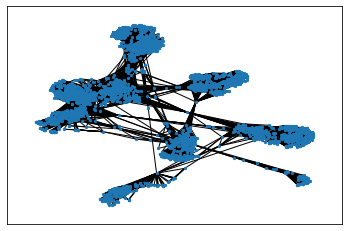

In [ ]:
nx.draw_networkx(G, with_labels=False, node_size=5, width=1)

## 2. (3 points) Top 10 Highest Degree Nodes

Find the 10 nodes with the highest degree.

In [ ]:
verticies_degrees_dict = dict()
# calculate the degree for each vertex
for v in list(G.nodes):
    verticies_degrees_dict[v] = vertexDegree(edges, v)
# get the top 10 highest values
top_10_highest_degree = topSortedDict(verticies_degrees_dict)

In [ ]:
# 10 nodes with the highest degree
list(top_10_highest_degree.keys())

[107, 1684, 1912, 3437, 0, 2543, 2347, 1888, 1800, 1663]

In [ ]:
# top 10 nodes with the highest degree - (node, degree)
convertDictToSortedList(top_10_highest_degree)

[(107, 1045),
 (1684, 792),
 (1912, 755),
 (3437, 547),
 (0, 347),
 (2543, 294),
 (2347, 291),
 (1888, 254),
 (1800, 245),
 (1663, 235)]

## 3. (3 points) Top 10 Highest Betweenness Centrality

Find the 10 nodes with the highest betweenness centrality.

In [ ]:
topSortedDict(nx.betweenness_centrality(G, normalized=False))

{0: 1192496.1130793944,
 58: 687594.983374667,
 107: 3916560.144440749,
 428: 524164.06777575763,
 567: 784996.9055941283,
 698: 940024.2464822,
 1085: 1214577.7583604807,
 1684: 2753286.686908284,
 1912: 1868918.212256787,
 3437: 1924506.1515714952}

## 4. (3 points) Top 10 Highest Clustering Coefficient

Find the 10 nodes with the highest clustering coefficient. If there are ties, choose 10 to report and explain how the 10 were chosen.

In [ ]:
verticies_clustering_coefficient_dict = dict()
# calculate the clustering coefficient for each vertex
for v in list(G.nodes):
    verticies_clustering_coefficient_dict[v] = vertexClusteringCoefficient(edges, v)
# get the top 10 highest values
top_10_highest_clustering_coefficient = topSortedDict(verticies_clustering_coefficient_dict)

In [ ]:
# 10 nodes with the greatest clustering coefficient
list(top_10_highest_clustering_coefficient.keys())

[32, 33, 35, 42, 44, 46, 47, 52, 63, 70]

In [ ]:
# top 10 nodes with the clustering coefficient - (node, degree)
convertDictToSortedList(top_10_highest_clustering_coefficient)

[(32, 1.0),
 (33, 1.0),
 (35, 1.0),
 (42, 1.0),
 (44, 1.0),
 (46, 1.0),
 (47, 1.0),
 (52, 1.0),
 (63, 1.0),
 (70, 1.0)]

## 5. (3 points) Top 10 Highest Prestige Centrality

Find the top 10 nodes as ranked by prestige centrality (eigenvector centrality in networkx).

In [ ]:
# prestige centrality
eigenvector_centrality = nx.eigenvector_centrality(G)
topSortedDict(eigenvector_centrality)

{1912: 0.09540696149067629,
 1993: 0.0835324284081597,
 2078: 0.08413617041724979,
 2123: 0.08367141238206226,
 2142: 0.08419311897991796,
 2206: 0.08605239270584343,
 2218: 0.08415573568055032,
 2233: 0.08517340912756598,
 2266: 0.08698327767886553,
 2464: 0.08427877475676092}

## 6. (3 points) Top 10 Highest Ranked by Pagerank

Find the top 10 nodes as ranked by Pagerank.

In [ ]:
topSortedDict(nx.pagerank(G))

{0: 0.006289602618466542,
 107: 0.006936420955866117,
 348: 0.002348096972780577,
 414: 0.001800299047070226,
 686: 0.002219359259800019,
 698: 0.0013171153138368812,
 1684: 0.006367162138306824,
 1912: 0.003876971600884498,
 3437: 0.0076145868447496,
 3980: 0.0021703235790099928}

## 7. (3 points) Commet on Diff. and Sim.

Comment on the differences and similarities in questions Part 3 1-6. Are the highly ranked nodes mostly the same? Do you notice significant differences in the rankings? Why do you think this is the case?

The highest degree a node had was 1045 and that was far from node 107. Node 107 also had a very high betweenness centrality which is expected as it has a large sum of paths leading to and from it. Node 107 was also seen to have a large PageRank value. This was also expected since a node that is pointed to repeatedly will have a higher PageRank and this logically follows that a node with a high degree will have lots of other nodes pointing to it. However, this node did not have a significant clustering coefficient or a high Prestige centrality. Additionally, Node 1912 had a top 10 rank for PageRank, Betweenness centrality, and Prestige centrality. This shows that there are multiple different nodes that could have a perceived "weight" to them and should be considered important. It is important to note that no node that ranked highly in the clustering coefficient ranked highly in any other category so it could be assumed that those nodes are very highly clustered but may not be highly clustered with the rest of the graph.

# Tips and Acknowledgements

Make sure to submit your answer as a PDF on Gradscope and Brightspace. Make sure to show your work. Include any code snippets you used to generate an answer, using comments in the code to clearly indicate which problem corresponds to which code.

**Acknowledgements**: Project adapted from assignments of Veronika Strnadova-Neeley.